Średni score na danych: 0.10119578911803366


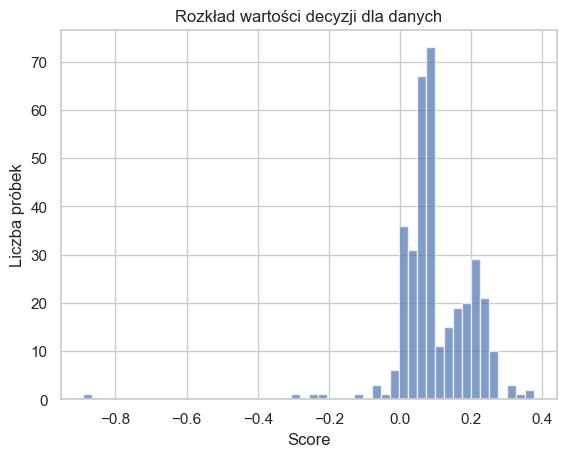

              precision    recall  f1-score   support

           0       0.44      0.53      0.48        15
           1       0.98      0.97      0.97       338

    accuracy                           0.95       353
   macro avg       0.71      0.75      0.73       353
weighted avg       0.96      0.95      0.95       353

Dokładność: 95.18%
Dokładność dla założonych anomalii: 8
Odsetek anomalii: 5.10%
False Positive Rate (FPR): 0.47


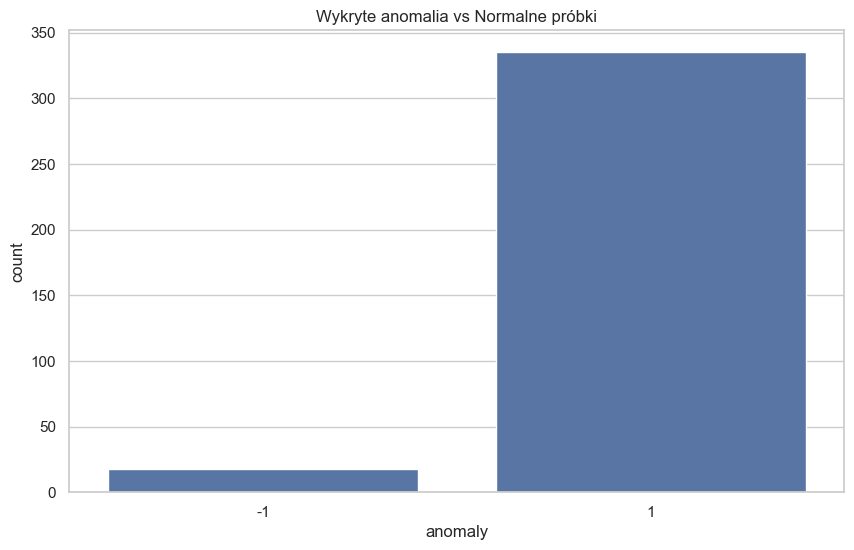

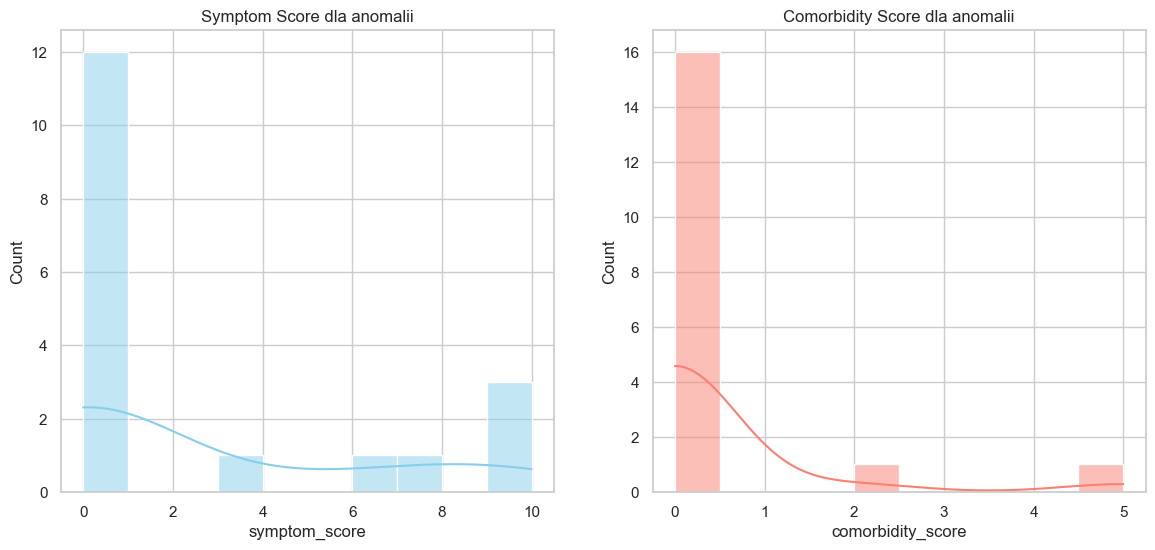

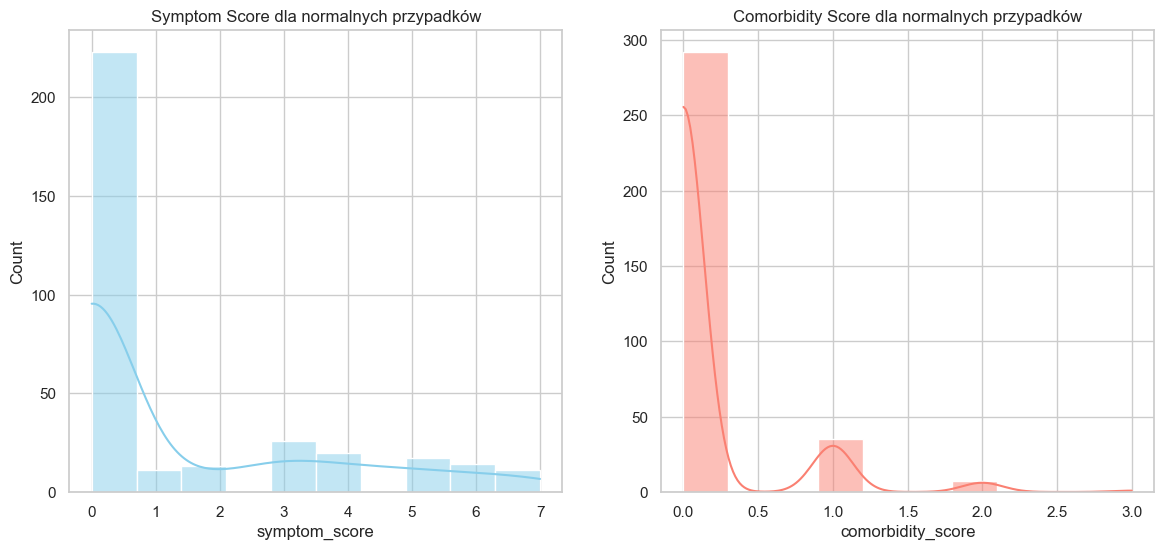

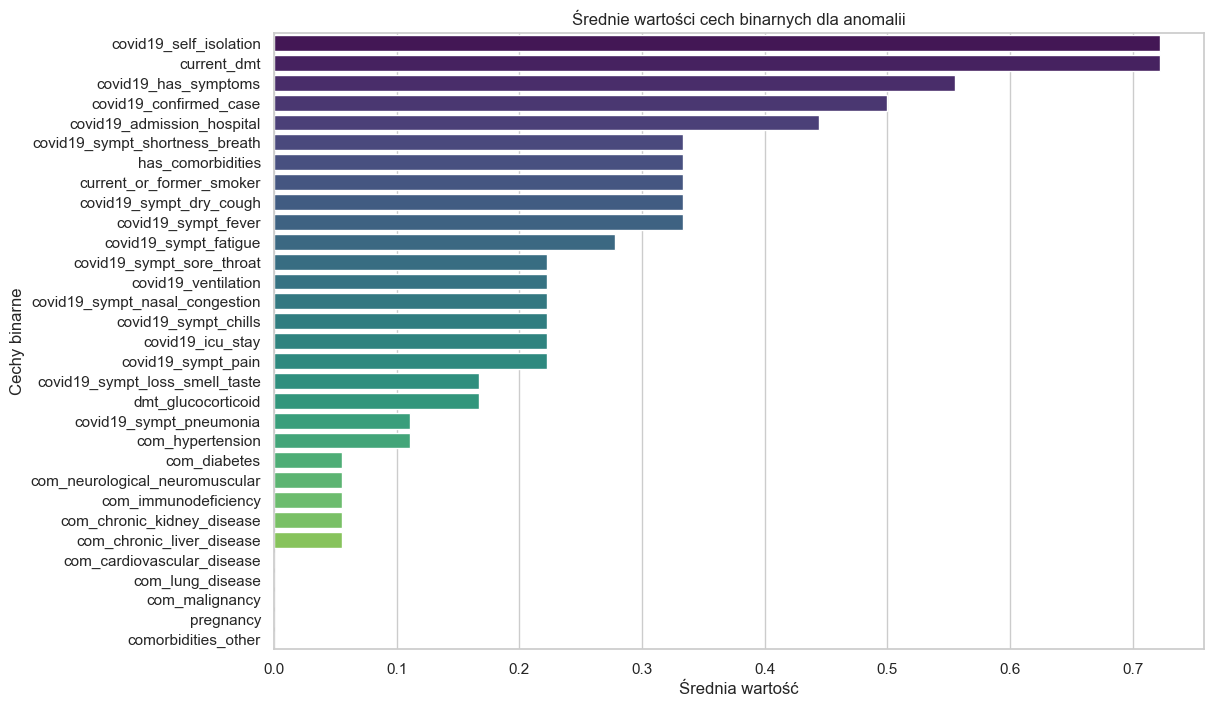

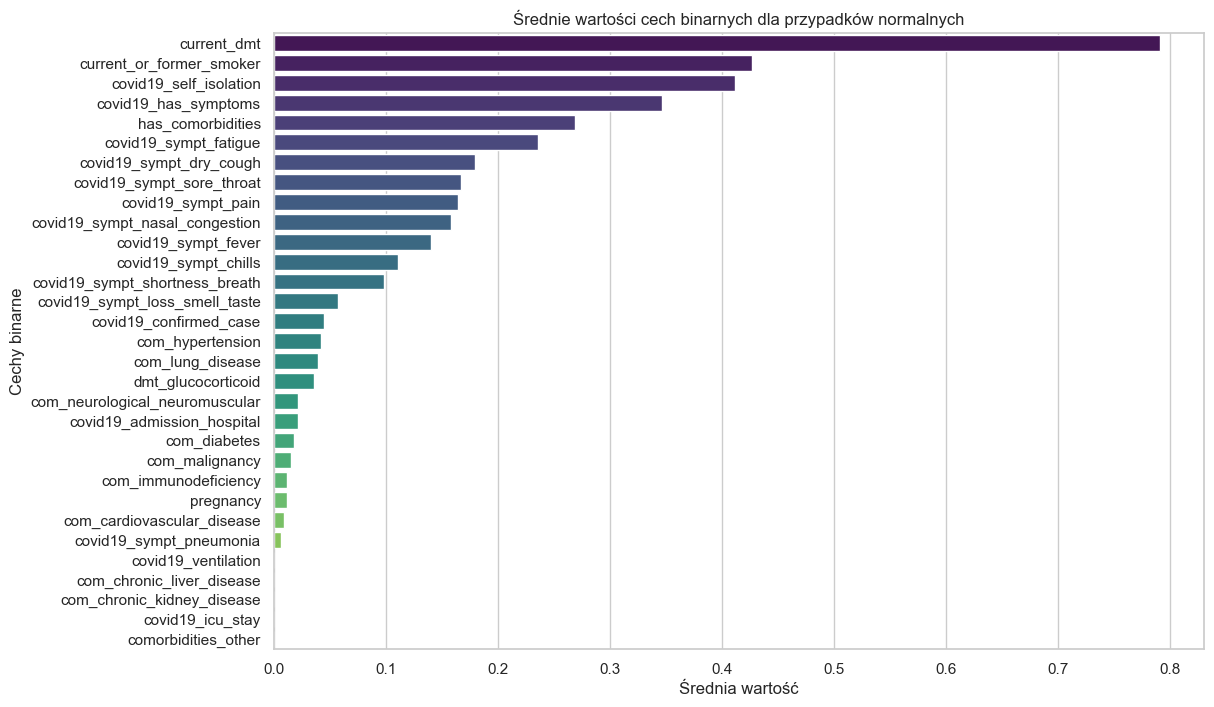

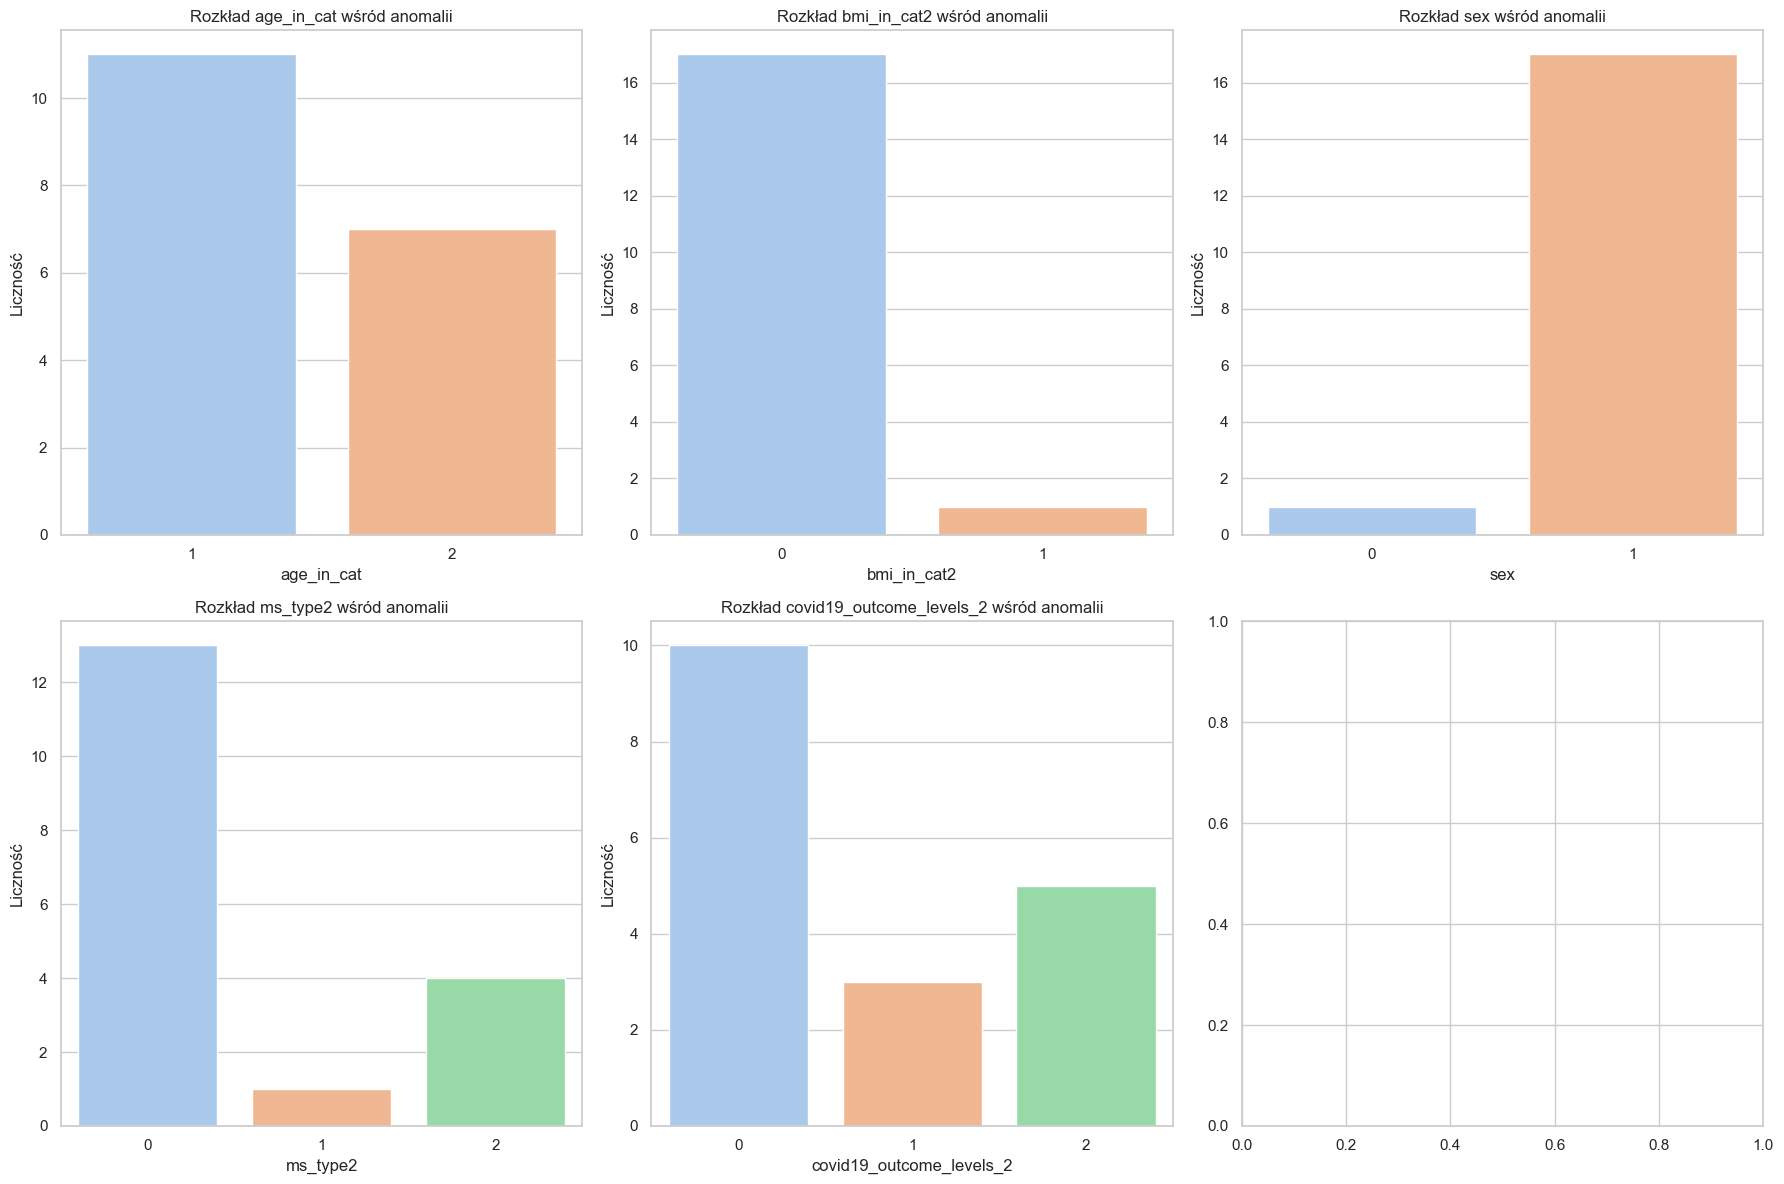

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

file = pd.read_csv('GDSI_OpenDataset_Final.csv', index_col=0)

features = ['report_source', 'age_in_cat', 'bmi_in_cat2', 'covid19_admission_hospital',  'covid19_confirmed_case', 'covid19_diagnosis', 'covid19_has_symptoms',
            'covid19_icu_stay', 'covid19_self_isolation', 'covid19_sympt_chills', 'covid19_sympt_dry_cough', 'covid19_sympt_fatigue', 'covid19_sympt_fever',
            'covid19_sympt_loss_smell_taste', 'covid19_sympt_nasal_congestion', 'covid19_sympt_pain', 'covid19_sympt_pneumonia', 'covid19_sympt_shortness_breath',
            'covid19_sympt_sore_throat', 'covid19_ventilation', 'current_dmt', 'dmt_glucocorticoid', 'edss_in_cat2', 'pregnancy', 'current_or_former_smoker',
            'has_comorbidities', 'com_cardiovascular_disease', 'com_chronic_kidney_disease', 'com_chronic_liver_disease', 'com_diabetes', 'com_hypertension',
            'com_immunodeficiency', 'com_lung_disease', 'com_malignancy', 'com_neurological_neuromuscular', 'comorbidities_other', 'dmt_type_overall',
            'covid19_outcome_levels_2', 'ms_type2', 'sex']
data = file[features].copy()

# Yes/No kolumny - czyszczenie
binary_columns = ['covid19_admission_hospital', 'covid19_confirmed_case', 'covid19_has_symptoms', 'covid19_icu_stay', 'covid19_self_isolation', 'covid19_sympt_chills',
                 'covid19_sympt_dry_cough', 'covid19_sympt_fatigue', 'covid19_sympt_fever', 'covid19_sympt_loss_smell_taste', 'covid19_sympt_nasal_congestion',
                 'covid19_sympt_pain', 'covid19_sympt_pneumonia', 'covid19_sympt_shortness_breath', 'covid19_sympt_sore_throat', 'covid19_ventilation', 'current_dmt',
                 'dmt_glucocorticoid', 'pregnancy', 'current_or_former_smoker', 'has_comorbidities', 'com_cardiovascular_disease', 'com_chronic_kidney_disease',
                 'com_chronic_liver_disease', 'com_diabetes', 'com_hypertension', 'com_immunodeficiency', 'com_lung_disease', 'com_malignancy',
                 'com_neurological_neuromuscular', 'comorbidities_other']

data[binary_columns] = data[binary_columns].map(lambda x: 1 if x == 'yes' else 0)
# Pozostale kolumny - czyszczenie
ordinal_mapping = {'age_in_cat': {'0': 0, '1': 1, '2': 2, '3': 3},
                   'covid19_outcome_levels_2': {'0': 0, '1': 1, '2': 2},
                   'report_source': {'clinicians': 1, 'patients': 0},
                   'bmi_in_cat2': {'not_overweight': 0, 'overweight': 1},
                   'covid19_diagnosis': {'not_suspected': 0, 'suspected': 1, 'confirmed': 2},
                   'current_dmt': {'yes': 2, 'no': 1, 'never_treated': 0},
                   'sex': {'male': 0, 'female': 1},
                   'ms_type2': {'relapsing_remitting': 0, 'progressive_MS': 1, 'other': 2},
                   'dmt_type_overall': {'No information on DMT use': 0,
                                        'currently not using any DMT': 1,
                                        'currently on interferon': 2, 
                                        'currently on glatiramer': 3,
                                        'currently on natalizumab': 4, 
                                        'currently on fingolimod': 5,
                                        'currently on dimethyl fumarate': 6,
                                        'currently on teriflunomide': 7,
                                        'currently on alemtuzumab': 8,
                                        'currently on cladribine': 9,
                                        'currently on siponimod': 10,
                                        'currently on rituximab': 11,
                                        'currently on ocrelizumab': 12,
                                        'currently on another drug not listed': 13},
                                        'covid19_outcome_recovered': {'no': 0, 'yes': 1, 'not_applicable':2}
                   }  
pd.set_option('future.no_silent_downcasting', True)
data.replace(ordinal_mapping, inplace=True)
# Zaminana nieznanych wartosci na zera
data.fillna(0, inplace=True)

# Zbieranie symptomow razem
symptom_columns = [col for col in data.columns if 'covid19_sympt_' in col]
comorbidity_columns = [col for col in data.columns if 'com_' in col]

data['symptom_score'] = data[symptom_columns].apply(lambda row: (row == 1).sum(), axis=1)
data['comorbidity_score'] = data[comorbidity_columns].apply(lambda row: (row == 1).sum(), axis=1)

# Odchylenie standardowe
scaler = StandardScaler()
# Skalowanie wybranych kolumn i dodanie wyników jako nowe kolumny
data['symptom_score_scaled'] = scaler.fit_transform(data[['symptom_score']])
data['comorbidity_score_scaled'] = scaler.fit_transform(data[['comorbidity_score']])

from sklearn.model_selection import train_test_split
# Podział na zbiór treningowy i testowy


data_without_admission_hospital = data[data['covid19_admission_hospital'] == 0]
data_admission_hospital = data[data['covid19_admission_hospital'] == 1]
X_train, X_test = train_test_split(data_without_admission_hospital, test_size=0.3, random_state=42)
X_test = pd.concat([X_test, data_admission_hospital], join='inner', ignore_index=True)

from sklearn.svm import OneClassSVM
# Trenowanie 
model = OneClassSVM(gamma='scale', kernel='rbf', nu=0.01)
model.fit(X_train)
predictions = model.predict(X_test)

import numpy as np

# Ocena na danych testowych
test_scores = model.decision_function(X_test)
print(f"Średni score na danych: {np.mean(test_scores)}")

# Wartości decyzji na danych treningowych
decision_scores = model.decision_function(X_test)

# Analiza rozkładu wartości decyzji
import matplotlib.pyplot as plt
plt.hist(decision_scores, bins=50, alpha=0.7)
plt.title("Rozkład wartości decyzji dla danych")
plt.xlabel("Score")
plt.ylabel("Liczba próbek")
plt.show()

X_test['anomaly'] = predictions
anomalies = X_test[predictions == -1]
normals = X_test[predictions == 1]

# Predykcje
final_data = X_test['covid19_admission_hospital']
y_pred_test = predictions

# Mapowanie wyników na 0 (nienormalne) i 1 (normalne)
final_data = [0 if x == 1 else 1 for x in final_data]
y_pred_test = [0 if x == -1 else 1 for x in y_pred_test]

# Raport klasyfikacji
#y_true = diagnosis_data['covid19_diagnosis'].values.tolist()
y_true = data_admission_hospital['covid19_admission_hospital'].values.tolist()
y_pred = y_pred_test

print(classification_report(final_data, y_pred, zero_division=0))
print(f"Dokładność: {accuracy_score(final_data, y_pred,) * 100:.2f}%")

takie_same = sum(1 for a, b in zip(final_data, y_pred,) if a == 0 and b == 0)
print(f"Dokładność dla założonych anomalii: {takie_same}")

# Obliczenie odsetka anomalii
anomaly_ratio = y_pred.count(0) / len(y_pred)
print(f"Odsetek anomalii: {anomaly_ratio:.2%}")

from sklearn.metrics import confusion_matrix
# Obliczanie macierzy konfuzji
tn, fp, fn, tp = confusion_matrix(final_data, y_pred,).ravel()

# Obliczanie FPR
fpr = fp / (fp + tn)

print(f"False Positive Rate (FPR): {fpr:.2f}")

# Wykresy
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x='anomaly', data=X_test)
plt.title('Wykryte anomalia vs Normalne próbki')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(anomalies['symptom_score'], bins=10, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title('Symptom Score dla anomalii')
sns.histplot(anomalies['comorbidity_score'], bins=10, kde=True, color='salmon', ax=ax[1])
ax[1].set_title('Comorbidity Score dla anomalii')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(normals['symptom_score'], bins=10, kde=True, color='skyblue', ax=ax[0])
ax[0].set_title('Symptom Score dla normalnych przypadków')
sns.histplot(normals['comorbidity_score'], bins=10, kde=True, color='salmon', ax=ax[1])
ax[1].set_title('Comorbidity Score dla normalnych przypadków')
plt.show()

binary_anomaly_means = anomalies[binary_columns].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=binary_anomaly_means.values, y=binary_anomaly_means.index, palette='viridis', hue=binary_anomaly_means.index , legend=False)
plt.title('Średnie wartości cech binarnych dla anomalii')
plt.xlabel('Średnia wartość')
plt.ylabel('Cechy binarne')
plt.show()

binary_normals_means = normals[binary_columns].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=binary_normals_means.values, y=binary_normals_means.index, palette='viridis', hue=binary_normals_means.index , legend=False)
plt.title('Średnie wartości cech binarnych dla przypadków normalnych')
plt.xlabel('Średnia wartość')
plt.ylabel('Cechy binarne')
plt.show()

categorical_columns = ['age_in_cat', 'bmi_in_cat2', 'sex', 'ms_type2', 'covid19_outcome_levels_2']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(data=anomalies, x=col, ax=axes[i], palette='pastel', hue=col, legend=False)
    axes[i].set_title(f'Rozkład {col} wśród anomalii')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Liczność')
plt.tight_layout()
plt.show()



#info które najlepsze do treningu
#param_grid = {
#    'nu': [0.05, 0.1, 0.2],
#    'gamma': ['scale', 'auto', 0.1, 1]
#}